In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd "/content/drive/My Drive/image caption/flask"

/content/drive/My Drive/image caption/flask


In [ ]:
!pip install fasttext
!sudo apt install tesseract-ocr
!pip install pytesseract
!pip install flask-ngrok
!pip install flask==0.12.2
!pip install tensorflow==1.14
!pip install keras==2.2.5

     |████████████████████████████████| 71kB 4.5MB/s 
  Created wheel for fasttext: filename=fasttext-0.9.2-cp36-cp36m-linux_x86_64.whl size=3018692 sha256=7926384483b239ad0d199cf0220b11e266bfe429a31f926f0ea9929e3d06a70f
  Stored in directory: /root/.cache/pip/wheels/98/ba/7f/b154944a1cf5a8cee91c154b75231136cc3a3321ab0e30f592
Successfully built fasttext
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 43 not upgraded.
Need to get 4,795 kB of archives.
After this operation, 15.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/univer

In [ ]:
from flask_ngrok import run_with_ngrok
from flask import Flask, render_template, request
from werkzeug.utils import secure_filename
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import sys
import json
from sklearn.utils import shuffle
from tqdm import tqdm
from numpy import array
import pandas as pd
import string
import os
import glob
import pickle
from time import time
from keras.preprocessing import sequence
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model
import fasttext
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from bs4 import BeautifulSoup
import string
import pytesseract
import shutil
import random
try:
 from PIL import Image
except ImportError:
 import Image
import tensorflow as tf
nltk.download('stopwords')
nltk.download('wordnet')

max_length = 43
incept = InceptionV3(weights='imagenet')
feature_extract_model = Model(incept.input, incept.layers[-2].output)
with open('../wordtoix.p', 'rb') as fp:
    wordtoix = pickle.load(fp)
with open('../ixtoword.p', 'rb') as fp:
    ixtoword = pickle.load(fp)
model = load_model('../model_9.h5')
txt_model = fasttext.load_model("../fasttext_model_zero.bin")

def greedySearch(photo,model):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        photo = np.array(photo)
        sequence = np.array(sequence)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

def clean_data(text):
  text = str(text)
  no_punct = "".join([c for c in text if c not in string.punctuation])
  url_pattern = r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
  text = re.sub(url_pattern, ' ', no_punct)
  text = ''.join(character for character in text if ord(character) < 128)
  emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
  text = emoji_pattern.sub(r'', text)
  toknizer = RegexpTokenizer(r'\w+')
  text = toknizer.tokenize(text.lower())
  text = [w for w in text if w not in stopwords.words('english')]
  lemmatizer = WordNetLemmatizer()
  text = [lemmatizer.lemmatize(i) for i in text]
  stemmer = PorterStemmer()
  text = " ".join([stemmer.stem(i) for i in  text])
  return text

def sentiment(result):
    if(result == '__label__positive'):
      return 'positive'
    elif(result == '__label__negative'):
      return 'negative'
    elif(result == '__label__neutral'):
      return 'neutral'

def model_predict(img_path,feature_extract_model,model,txt_model):
    img = image.load_img(img_path, target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    print("Iamge Fetched")
    fea_vec = feature_extract_model.predict(x) 
    print("Features Fetched")
    img = np.reshape(fea_vec, fea_vec.shape[1]) 
    img = img.reshape((1,2048))
    print("Feature Reshape")
    caption = greedySearch(img,model)
    print("Captioned: ",caption)
    ocr = pytesseract.image_to_string(Image.open(img_path))
    print("OCR: ",ocr)
    result = txt_model.predict(clean_data(ocr+' '+caption))
    print(result)
    return sentiment(result[0][0])

app = Flask(__name__)
run_with_ngrok(app)

@app.route("/")
def home():
    return render_template('index.html')

@app.route('/predict', methods=['POST'])
def upload():
    f = request.files['file']
    basepath = '/content/drive/My Drive/image caption/flask/user/'
    file_path = os.path.join(basepath, 'uploads', secure_filename(f.filename))
    f.save(file_path)
    print("Save file")
    preds = model_predict(file_path,feature_extract_model,model,txt_model)
    return preds

if __name__ == '__main__':
    app.run()

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.








96116736/96112376 [==============================] - 4s 0us/step
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


 * Running on http://de6df6e2c864.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040


127.0.0.1 - - [17/Jun/2020 05:22:51] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [17/Jun/2020 05:22:53] "GET /static/css/main.css HTTP/1.1" 200 -
127.0.0.1 - - [17/Jun/2020 05:22:54] "GET /static/js/main.js HTTP/1.1" 200 -
127.0.0.1 - - [17/Jun/2020 05:22:55] "GET /favicon.ico HTTP/1.1" 404 -


Save file
Iamge Fetched
Features Fetched
Feature Reshape
Captioned:  man is standing on the floor with bat
OCR:  an =
Guns carry him for protection.
~~ .

—


127.0.0.1 - - [17/Jun/2020 05:23:12] "POST /predict HTTP/1.1" 200 -


(('__label__negative',), array([0.73301888]))


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import sys
import json
from sklearn.utils import shuffle
from tqdm import tqdm
from numpy import array
import pandas as pd
import string
import os
import glob
import pickle
from time import time
from keras.preprocessing import sequence
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
import fasttext
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from bs4 import BeautifulSoup
import string
import pytesseract
import shutil
import random
try:
 from PIL import Image
except ImportError:
 import Image
nltk.download('stopwords')
nltk.download('wordnet')

max_length = 43
incept = InceptionV3(weights='imagenet')
feature_extract_model = Model(incept.input, incept.layers[-2].output)
with open('../wordtoix.p', 'rb') as fp:
    wordtoix = pickle.load(fp)
with open('../ixtoword.p', 'rb') as fp:
    ixtoword = pickle.load(fp)
model = load_model('../model_9.h5')
txt_model = fasttext.load_model("../fasttext_model_zero.bin")

def greedySearch(photo,model):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        photo = np.array(photo)
        sequence = np.array(sequence)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

def clean_data(text):
  text = str(text)
  no_punct = "".join([c for c in text if c not in string.punctuation])
  url_pattern = r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
  text = re.sub(url_pattern, ' ', no_punct)
  text = ''.join(character for character in text if ord(character) < 128)
  emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
  text = emoji_pattern.sub(r'', text)
  toknizer = RegexpTokenizer(r'\w+')
  text = toknizer.tokenize(text.lower())
  text = [w for w in text if w not in stopwords.words('english')]
  lemmatizer = WordNetLemmatizer()
  text = [lemmatizer.lemmatize(i) for i in text]
  stemmer = PorterStemmer()
  text = " ".join([stemmer.stem(i) for i in  text])
  return text

def model_predict(img_path,feature_extract_model,model,txt_model):
    img = image.load_img(img_path, target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    fea_vec = feature_extract_model.predict(x) 
    img = np.reshape(fea_vec, fea_vec.shape[1]) 
    img = img.reshape((1,2048))
    caption = greedySearch(img,model)
    x=plt.imread(img_path)
    plt.imshow(x)
    plt.show()
    return txt_model.predict(clean_data(pytesseract.image_to_string(Image.open('/content/drive/My Drive/image caption/flask/user/uploads/image_1.jpg'))+' '+caption))

Using TensorFlow backend.


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
96116736/96112376 [==============================] - 1s 0us/step


In [ ]:
def sentiment(result):
    if(result == '__label__positive'):
      return 'positive'
    elif(result == '__label__negative'):
      return 'negative'
    elif(result == '__label__neutral'):
      return 'neutral'

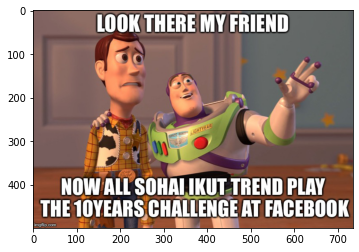

sentiment:  positive


In [ ]:
result = model_predict('/content/drive/My Drive/image caption/flask/user/uploads/image_1.jpg',feature_extract_model,model,txt_model)
print("sentiment: ", sentiment(result[0][0]))